## Analysis of Clandinin Data
### Brandon Pratt, 08/28/2020

In [1]:
# import python libraries
import h5py
import os
import math

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal

from scipy import signal
from scipy import interpolate


In [6]:
def org_data(formatted_data):
    
    # isolate the x and y positions of the body labels
    head=formatted_data[:,0:2]
    thorax=formatted_data[:,3:5]
    abdomen=formatted_data[:,6:8]
    l1=formatted_data[:,9:11]
    l2=formatted_data[:,12:14]
    l3=formatted_data[:,15:17]
    r1=formatted_data[:,18:20]
    r2=formatted_data[:,21:23]
    r3=formatted_data[:,24:26]

    # correct for mirroring along the yaxis
    head[:,1]=-head[:,1]
    thorax[:,1]=-thorax[:,1]
    abdomen[:,1]=-abdomen[:,1]
    l1[:,1]=-l1[:,1]
    l2[:,1]=-l2[:,1]
    l3[:,1]=-l3[:,1]
    r1[:,1]=-r1[:,1]
    r2[:,1]=-r2[:,1]
    r3[:,1]=-r3[:,1]

    # normalize the leg positions by thorax position
    norm_head=head-thorax
    norm_abdomen=abdomen-thorax
    norm_l1=l1-thorax
    norm_l2=l2-thorax
    norm_l3=l3-thorax
    norm_r1=r1-thorax
    norm_r2=r2-thorax
    norm_r3=r3-thorax
   
    fps=124
    nframes=len(norm_l1)
    time=np.linspace(0, nframes/fps, nframes)

    # Align fly to heading
    r1_x = norm_r1[:,0]
    r1_y = norm_r1[:,1]

    r2_x = norm_r2[:,0]
    r2_y = norm_r2[:,1] 

    r3_x = norm_r3[:,0]
    r3_y = norm_r3[:,1] 

    l1_x = norm_l1[:,0]
    l1_y = norm_l1[:,1]

    l2_x = norm_l2[:,0]
    l2_y = norm_l2[:,1] 

    l3_x = norm_l3[:,0]
    l3_y = norm_l3[:,1]

    hx=norm_head[:,0]
    hy=norm_head[:,1]

    ax=norm_abdomen[:,0]
    ay=norm_abdomen[:,1]

    # store variables
    n_frames=len(hx)
    new_hx=np.zeros(n_frames)
    new_hy=np.zeros(n_frames)
    new_ax=np.zeros(n_frames)
    new_ay=np.zeros(n_frames)
    new_r1_x=np.zeros(n_frames)
    new_r1_y=np.zeros(n_frames)
    new_r2_x=np.zeros(n_frames)
    new_r2_y=np.zeros(n_frames)
    new_r3_x=np.zeros(n_frames)
    new_r3_y=np.zeros(n_frames)
    new_l1_x=np.zeros(n_frames)
    new_l1_y=np.zeros(n_frames)
    new_l2_x=np.zeros(n_frames)
    new_l2_y=np.zeros(n_frames)
    new_l3_x=np.zeros(n_frames)
    new_l3_y=np.zeros(n_frames)
    h_angle=np.zeros(n_frames)


    for j in range(n_frames):

        # compute heading angle
        if hx[j]<0:
            sign=-1
            mirror_x=-1 # mirror across x
            mirror_y=-1 # mirror across y

        else:
            sign=1
            mirror_x=1
            mirror_y=1
        l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
        heading_angle=math.asin(hy[j]/l_head) # headin angle in radians
        h_angle[j]=heading_angle
        # new head positions
        new_hx[j]=mirror_x*l_head
        new_hy[j]=0 # heading angle should become zero

        # new abdomen position
        if ax[j]<0:
            sign=-1
        else:
            sign=1
        l_abdo=sign*math.sqrt(ax[j]**2 + ay[j]**2)
        abdo_angle=math.asin(ay[j]/l_abdo)
        new_abdo_angle=abdo_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_ax[j]=mirror_x*l_abdo*math.cos(new_abdo_angle)
        new_ay[j]=mirror_y*l_abdo*math.sin(new_abdo_angle)

        # compute the new 2D position of each leg
        # r1
        if r1_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r1=sign*math.sqrt(r1_x[j]**2 + r1_y[j]**2)
        r1_angle=math.asin(r1_y[j]/l_r1)
        new_r1_angle=r1_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r1_x[j]=mirror_x*l_r1*math.cos(new_r1_angle)
        new_r1_y[j]=mirror_y*l_r1*math.sin(new_r1_angle)

        # r2
        if r2_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r2=sign*math.sqrt(r2_x[j]**2 + r2_y[j]**2)
        r2_angle=math.asin(r2_y[j]/l_r2)
        new_r2_angle=r2_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r2_x[j]=mirror_x*l_r2*math.cos(new_r2_angle)
        new_r2_y[j]=mirror_y*l_r2*math.sin(new_r2_angle)

        # r3
        if r3_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r3=sign*math.sqrt(r3_x[j]**2 + r3_y[j]**2)
        r3_angle=math.asin(r3_y[j]/l_r3)
        new_r3_angle=r3_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r3_x[j]=mirror_x*l_r3*math.cos(new_r3_angle)
        new_r3_y[j]=mirror_y*l_r3*math.sin(new_r3_angle)

        # l1
        if l1_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l1=sign*math.sqrt(l1_x[j]**2 + l1_y[j]**2)
        l1_angle=math.asin(l1_y[j]/l_l1)
        new_l1_angle=l1_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l1_x[j]=mirror_x*l_l1*math.cos(new_l1_angle)
        new_l1_y[j]=mirror_y*l_l1*math.sin(new_l1_angle)

        # l2
        if l2_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l2=sign*math.sqrt(l2_x[j]**2 + l2_y[j]**2)
        l2_angle=math.asin(l2_y[j]/l_l2)
        new_l2_angle=l2_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l2_x[j]=mirror_x*l_l2*math.cos(new_l2_angle)
        new_l2_y[j]=mirror_y*l_l2*math.sin(new_l2_angle)

        # l3
        if l3_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l3=sign*math.sqrt(l3_x[j]**2 + l3_y[j]**2)
        l3_angle=math.asin(l3_y[j]/l_l3)
        new_l3_angle=l3_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l3_x[j]=mirror_x*l_l3*math.cos(new_l3_angle)
        new_l3_y[j]=mirror_y*l_l3*math.sin(new_l3_angle)

    # store leg arrays
    x_pos=[new_r1_x, new_r2_x, new_r3_x, new_l1_x, new_l2_x, new_l3_x]
    y_pos=[new_r1_y, new_r2_y, new_r3_y, new_l1_y, new_l2_y, new_l3_y]

    # store rotated body arrays
    rot_head=[new_hx, new_hy]
    rot_abdomen=[new_ax, new_ay]
    
    return x_pos, y_pos, head, thorax, abdomen

In [3]:
def find_stance_swing(smooth_x_pos): 

    # find peaks parameters
    prom=8
    w=0
    dist=1
    fps=124
    nframes=len(smooth_x_pos[0])

    # find the indices of local maximums (stance start)
    r1_max_pks, r1_max_properties = scipy.signal.find_peaks(smooth_x_pos[0], prominence=prom, width=w, distance=dist)
    r2_max_pks, r2_max_properties = scipy.signal.find_peaks(smooth_x_pos[1], prominence=prom, width=w, distance=dist)
    r3_max_pks, r3_max_properties = scipy.signal.find_peaks(smooth_x_pos[2], prominence=prom, width=w, distance=dist)
    l1_max_pks, l1_max_properties = scipy.signal.find_peaks(smooth_x_pos[3], prominence=prom, width=w, distance=dist)
    l2_max_pks, l2_max_properties = scipy.signal.find_peaks(smooth_x_pos[4], prominence=prom, width=w, distance=dist)
    l3_max_pks, l3_max_properties = scipy.signal.find_peaks(smooth_x_pos[5], prominence=prom, width=w, distance=dist)

    # collect the all of the stance starts starting from the second one to the second to last one
    stance_start=[r1_max_pks[1:-1], r2_max_pks[1:-1], r3_max_pks[1:-1], l1_max_pks[1:-1], l2_max_pks[1:-1], l3_max_pks[1:-1]]

    # find the indices of local maximums (swing start)
    r1_min_pks, r1_min_properties = scipy.signal.find_peaks(-smooth_x_pos[0], prominence=prom, width=w, distance=dist)
    r2_min_pks, r2_min_properties = scipy.signal.find_peaks(-smooth_x_pos[1], prominence=prom, width=w, distance=dist)
    r3_min_pks, r3_min_properties = scipy.signal.find_peaks(-smooth_x_pos[2], prominence=prom, width=w, distance=dist)
    l1_min_pks, l1_min_properties = scipy.signal.find_peaks(-smooth_x_pos[3], prominence=prom, width=w, distance=dist)
    l2_min_pks, l2_min_properties = scipy.signal.find_peaks(-smooth_x_pos[4], prominence=prom, width=w, distance=dist)
    l3_min_pks, l3_min_properties = scipy.signal.find_peaks(-smooth_x_pos[5], prominence=prom, width=w, distance=dist)


    # captured swing transitions...need to match them to the stance_transitions
    swing_transitions=[r1_min_pks, r2_min_pks, r3_min_pks, l1_min_pks, l2_min_pks, l3_min_pks]

    # determine match pairs
    stance_end=[] # store the corresponding stance ends
    for leg in range(len(stance_start)):
        leg_stances=stance_start[leg]

        # initialize the array for swing mathes
        swing_matches=np.zeros(len(leg_stances))

        # go through each stance and determine the follwoing swing time
        for j in range(len(leg_stances)):
            curr_stance = leg_stances[j]

            #find the closest swing
            diff_swing_stance = swing_transitions[leg]-curr_stance

            # ignore negative values
            pos_idxs = np.where(diff_swing_stance>0)[0]

            # match the index to the swing
            #deal with the boundary condition of not finding a corresponding swing
            if len(pos_idxs)==0:
                # take out the stance that doesn't have a match
                stance_start[leg]=leg_stances[0:j-1]
                swing_matches=swing_matches[0:j-1]
                break
            else:
                # find the index of the closest swing
                pos_vals=diff_swing_stance[pos_idxs]
                min_idx = np.argmin(pos_vals)
                swing_match=swing_transitions[leg][np.where(pos_vals[min_idx]==diff_swing_stance)[0]]
                swing_matches[j]=swing_match

        # append the matched seing transitions to the stance ends
        stance_end.append(swing_matches.astype(int))

    # construct swing stance matrix
    nlegs=6
    stance_threshold=5
    swing_stance_mat=np.zeros([nlegs,nframes])
    for leg in range(0,len(stance_start)):
        # use each stance start as a point of reference and find the next stance end point
        for stance in range(0,len(stance_start[leg])):
            frames_stance=round(stance_end[leg][stance]-stance_start[leg][stance])
            if frames_stance>stance_threshold:
                swing_stance_mat[leg][stance_start[leg][stance]:stance_end[leg][stance]]=1
            else:
                pass

    # filter swing stance plot based on the number of frames during swing phase
    swing_threshold=5
    for leg in range(0,len(stance_start)):
        # use each stance start as a point of reference and find the next stance end point
        for stance in range(len(stance_start[leg])-1):
            frames_swing=stance_start[leg][stance+1]-stance_end[leg][stance]
            if frames_swing < swing_threshold:
                swing_stance_mat[leg][stance_end[leg][stance]:stance_start[leg][stance+1]]=1
            else:
                pass
            
    return swing_stance_mat, stance_start, stance_end

In [4]:
def compute_tcs(stance_start, stance_end):
    FS=124
    # Tripod Coordination Strength
    #right_tripod
    r1_stances = stance_start[0]
    r1_swings = stance_end[0]
    l2_stances = stance_start[4]
    l2_swings = stance_end[4]
    r3_stances = stance_start[2]
    r3_swings = stance_end[2]

    # tolerance of a tripods leg entering stance relative to the onset of swing of the reference leg
    tol = 3

    # storage lists
    right_tsc=[]
    right_tsc_time=[]

    # determine the closest stance start of l2 and r3 to that of r1
    for j in range(len(r1_stances)):

        # match stances of a step with reference of those of r1
        ref_stance = r1_stances[j]

        # find the closest indices
        diff_l2=l2_stances-ref_stance
        diff_r3=r3_stances-ref_stance

        # convert negative values into positive values because want jsut the magnitude
        l2_neg_idxs = np.where(diff_l2 <0)[0]
        diff_l2[l2_neg_idxs]=-diff_l2[l2_neg_idxs]
        r3_neg_idxs = np.where(diff_r3 <0)[0]
        diff_r3[r3_neg_idxs]=-diff_r3[r3_neg_idxs]

        # find the minimum idx
        l2_min_idx=np.argmin(diff_l2)
        l2_match_stance=l2_stances[l2_min_idx]
        r3_min_idx=np.argmin(diff_r3)
        r3_match_stance=r3_stances[r3_min_idx]

        # only continue calculate tcs if the stance onsets of l2 and r3 are less than the swing onset of r1 minus a tolerance
        ref_swing=r1_swings[j]
        if (l2_match_stance < (ref_swing-tol)) and (r3_match_stance < (ref_swing-tol)):
            # find the corresponding swing times
             # find the closest indices
            diff_l2=l2_swings-ref_swing
            diff_r3=r3_swings-ref_swing

            # convert negative values into positive values because want jsut the magnitude
            l2_neg_idxs = np.where(diff_l2 <0)[0]
            diff_l2[l2_neg_idxs]=-diff_l2[l2_neg_idxs]
            r3_neg_idxs = np.where(diff_r3 <0)[0]
            diff_r3[r3_neg_idxs]=-diff_r3[r3_neg_idxs]

            # find the minimum idx
            l2_min_idx=np.argmin(diff_l2)
            l2_match_swing=l2_swings[l2_min_idx]
            r3_min_idx=np.argmin(diff_r3)
            r3_match_swing=r3_swings[r3_min_idx]

            # calculate t1: duration legs are in stance together
            # comute the max of those legs in stance
            last_stance=max(np.array([ref_stance, l2_match_stance, r3_match_stance]))
            first_swing=min(np.array([ref_swing, l2_match_swing, r3_match_swing]))
            t1=(first_swing-last_stance)/FS

            # calculate t2: total time that elapsed from the first leg entering stance and the last leg entering swing
            first_stance=min(np.array([ref_stance, l2_match_stance, r3_match_stance]))
            last_swing=max(np.array([ref_swing, l2_match_swing, r3_match_swing]))
            t2=(last_swing-first_stance)/FS

            # compute tcs, ratio of t1/t2
            if (t1>0) and (t2>0): # just in case of missed indices
                tcs=t1/t2
                right_tsc.append(tcs)
                right_tsc_time.append(ref_stance)

    #         print(j)
    #         print('r1 stance: ', ref_stance)
    #         print('l2 stance: ', l2_match_stance)
    #         print('r3 stance: ', r3_match_stance)
    #         print('r1 swing: ', ref_swing)
    #         print('l2 swing: ', l2_match_swing)
    #         print('r3 swing: ', r3_match_swing)
    #         print('tcs: ', tcs)

        else: 
            pass



    #left_tripod
    l1_stances = stance_start[3]
    l1_swings = stance_end[3]
    r2_stances = stance_start[1]
    r2_swings = stance_end[1]
    l3_stances = stance_start[5]
    l3_swings = stance_end[5]


    # storage lists
    left_tsc=[]
    left_tsc_time=[]

    # determine the closest stance start of l2 and r3 to that of r1
    for j in range(len(l1_stances)):

        # match stances of a step with reference of those of r1
        ref_stance = l1_stances[j]

        # find the closest indices
        diff_r2=r2_stances-ref_stance
        diff_l3=l3_stances-ref_stance

        # convert negative values into positive values because want jsut the magnitude
        r2_neg_idxs = np.where(diff_r2 <0)[0]
        diff_r2[r2_neg_idxs]=-diff_r2[r2_neg_idxs]
        l3_neg_idxs = np.where(diff_l3 <0)[0]
        diff_l3[l3_neg_idxs]=-diff_l3[l3_neg_idxs]

        # find the minimum idx
        r2_min_idx=np.argmin(diff_r2)
        r2_match_stance=r2_stances[r2_min_idx]
        l3_min_idx=np.argmin(diff_l3)
        l3_match_stance=l3_stances[l3_min_idx]

        # only continue calculate tcs if the stance onsets of l2 and r3 are less than the swing onset of r1 minus a tolerance
        ref_swing=l1_swings[j]
        if (r2_match_stance < (ref_swing-tol)) and (l3_match_stance < (ref_swing-tol)):
            # find the corresponding swing times
             # find the closest indices
            diff_r2=r2_swings-ref_swing
            diff_l3=l3_swings-ref_swing

            # convert negative values into positive values because want jsut the magnitude
            r2_neg_idxs = np.where(diff_r2 <0)[0]
            diff_r2[r2_neg_idxs]=-diff_r2[r2_neg_idxs]
            l3_neg_idxs = np.where(diff_l3 <0)[0]
            diff_l3[l3_neg_idxs]=-diff_l3[l3_neg_idxs]

            # find the minimum idx
            r2_min_idx=np.argmin(diff_r2)
            r2_match_swing=r2_swings[r2_min_idx]
            l3_min_idx=np.argmin(diff_l3)
            l3_match_swing=l3_swings[l3_min_idx]

            # calculate t1: duration legs are in stance together
            # comute the max of those legs in stance
            last_stance=max(np.array([ref_stance, r2_match_stance, l3_match_stance]))
            first_swing=min(np.array([ref_swing, r2_match_swing, l3_match_swing]))
            t1=(first_swing-last_stance)/FS

            # calculate t2: total time that elapsed from the first leg entering stance and the last leg entering swing
            first_stance=min(np.array([ref_stance, r2_match_stance, l3_match_stance]))
            last_swing=max(np.array([ref_swing, r2_match_swing, l3_match_swing]))
            t2=(last_swing-first_stance)/FS

            # compute tcs, ratio of t1/t2
            if (t1 > 0) and (t2 > 0): # just in case of missed indices
                tcs=t1/t2
                left_tsc.append(tcs)
                left_tsc_time.append(ref_stance)

    #         print(j)
    #         print('l1 stance: ', ref_stance)
    #         print('r2 stance: ', r2_match_stance)
    #         print('l3 stance: ', l3_match_stance)
    #         print('l1 swing: ', ref_swing)
    #         print('r2 swing: ', r2_match_swing)
    #         print('l3 swing: ', l3_match_swing)
    #         print('tcs: ', tcs)
    #         print('t1: ', t1)
    #         print('t2: ', t2)

        else: 
            pass

    # combine the tripod coordination results of the right and left legs
    combined_tcs=np.concatenate([np.array(right_tsc), np.array(left_tsc)])
    combined_tcs_frame=np.concatenate([np.array(right_tsc_time), np.array(left_tsc_time)])

    # sort indices
    sort_idxs=np.argsort(combined_tcs_frame)
    sorted_tcs_frames=combined_tcs_frame[sort_idxs]
    sorted_tcs=combined_tcs[sort_idxs]


    #     # plot tripod coordination strength
    #     plt.figure(1, figsize=[10,5])
    #     plt.plot(sorted_tcs_frames, sorted_tcs, color='black', linewidth=1.5)
    #     plt.xlabel('Frame (#)', fontsize=18)
    #     plt.ylabel('TCS', fontsize=18)


    # compute stats of tcs
    mean_tcs=np.nanmean(sorted_tcs)
    std_tcs=np.nanstd(sorted_tcs)
    tcs_stat=[mean_tcs, std_tcs]

#     # plot a histogram
#     plt.figure(1, figsize=[10,10])
#     plt.hist(sorted_tcs, bins=20,density=True)
#     plt.ylabel('pdf', fontsize=16)
#     plt.xlabel('Tripod Coordination Strength', fontsize=16)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.title('Tripod Coordination Strength', fontsize=18)

    return tcs_stat, sorted_tcs


In [5]:
# smooth the correct velocity
def smooth_velocity(corr_vel):
    window=100
    total_window = len(corr_vel)
    smoothed_vel = np.zeros(total_window)
    idx_start = 0
    center = round(window/2)
    for j in range(total_window - window):
        idx_end = idx_start + window
        smoothed_vel[center] = np.mean(corr_vel[idx_start:idx_end])
        idx_start = idx_start+1
        center = center+1

    # pad the edges of the smoothed velocity with the original corr velocity values
    smoothed_vel[0:round(window/2)] = corr_vel[0:round(window/2)]
    smoothed_vel[-round(window/2):-1] = corr_vel[-round(window/2):-1]
    
    return smoothed_vel

In [13]:
base_dir='G:/My Drive/Tuthill Lab Shared/Brandon/cl/v/white background data/'
vel_dir = 'G:/My Drive/Tuthill Lab Shared/Brandon/cl/velocity/'
# 'erecta', 'arizonae', 'mauritiana', 'melanogaster_isod1', 'melanogaster_la66', 'melanogaster_la69', 'melanogaster_z56', 'melanogaster_z58',
#'melanogaster_z530', 'melanogaster_zh16', 'melanogaster_zh18','melanogaster_zh20', 'melanogaster_zh27', 'melanogaster_zh29', 'melanogaster_zh32',
#'melanogaster_zh33', 'melanogaster_zh34', 'melanogaster_zh42', 'melanogaster_zh47', 'melanogaster_zh58', 'persimilis',
#               'pseudoobscura', 'santomea', 'sechellia', 'simulans', 'teissieri', 'virilis', 'willistoni', 
species_names=['arizonae', 'erecta', 'mauritiana', 'melanogaster', 'persimilis', 'pseudoobscura',
               'santomea','simulans','virilis','willistoni','yakuba']

#'erecta', 'la66', 'la69','mauritiana', 'sechellia',
legs_in_stance=[]
for species in range(len(species_names)):
    print(species_names[species])
    species_dir = base_dir + species_names[species] + '/pose-2d-filtered/'
    filenames = sorted(os.listdir(species_dir))
    type_filename=[]
    
    # collect and sort all of the filenames of a given species
    for file in range(len(filenames)):
        if filenames[file][-3::] =='.h5':
            type_filename.append(filenames[file])

    # iterate through files and collect those that belong to each other
    group_filenames=[]
    count=0
    for i in range(len(type_filename)-1):#range(len(unique_trials)):
        if count == 0:
            group_files=[]
        # last value
        trial_n1 = int(type_filename[i][-5])
        trial_n2 = int(type_filename[i+1][-5])
        
        if trial_n2 > trial_n1:
            group_files.append(type_filename[i])
            count=count+1
        else:
            count = 0
            group_files.append(type_filename[i])
            group_filenames.append(group_files)
        if i+1 == len(type_filename)-1:
            group_files.append(type_filename[i+1])
            group_filenames.append(group_files)
            
            
        
    # iterate through grouped filenames
    for n in range(len(group_filenames)):
        filtered_filename = group_filenames[n]

        # combine the files
        # condition where there is just one file 
        # loading in their data

        # load file
        h5 = h5py.File(species_dir+ filtered_filename[0],'r')
        data=h5['df_with_missing']['table']

        # need to combine into a matrix
        formatted_data=np.zeros((len(data),len(data[0][1])))
        for j in range(len(data)):
            formatted_data[j,:]=np.array(data[j][1])

        print('file row', data[0][1])
        del h5
        del data


        if len(filtered_filename)>1:
            for a in range(len(filtered_filename)-1):
                # loading in their data

                # load file
                h5 = h5py.File(species_dir+ filtered_filename[a+1],'r')
                data=h5['df_with_missing']['table']
                print(data.shape)

                # need to combine into a matrix
                temp_formatted_data=np.zeros((len(data),len(data[0][1])))
                for j in range(len(data)):
                    temp_formatted_data[j,:]=np.array(data[j][1])
                print('file row', data[0][1])

                del h5
                del data

                # concatenate data associated with a particular file
                formatted_data = np.concatenate((formatted_data, temp_formatted_data))
                
#         # load velocity data
#         # adjust filename to be consisent with that of the velocity filenaming scheme
#         adj_filename=filtered_filename[0][0:5] + '-' + filtered_filename[0][6:7]+'-'+filtered_filename[0][8:16]+'-'+filtered_filename[0][17:23]
        
#         # isolate first part of the filename
#         vel_filename = vel_dir + species_names[species]+'_' + adj_filename+'._vel.csv'
        
#         vel_df = pd.read_csv(vel_filename)
#         velocity_values=vel_df.values[0]
        
#         # interpolate velocity to so that it matches the number of frames
#         x=np.arange(0, len(velocity_values))
#         f = interpolate.interp1d(x, velocity_values)

#         xnew = np.linspace(0, len(velocity_values)-1, formatted_data.shape[0]) #18942
#         corr_vel = f(xnew)
        
#         # smooth velocity
#         smoothed_vel = smooth_velocity(corr_vel)
        
        # organize data
        [x_pos, y_pos, head, thorax, abdomen] = org_data(formatted_data)
            
        # smooth x position
        win_size=10
        win_edge=int(np.floor(win_size/2))
        smooth_x_pos=[]
        smooth_y_pos=[]
        for leg in range(len(x_pos)):
            filt_x_pos=np.zeros(len(x_pos[0]))
            filt_x_pos[0:win_size]=x_pos[leg][0:win_size]
            filt_x_pos[-win_size::]=x_pos[leg][-win_size::]

            filt_y_pos=np.zeros(len(y_pos[0]))
            filt_y_pos[0:win_size]=y_pos[leg][0:win_size]
            filt_y_pos[-win_size::]=y_pos[leg][-win_size::]
            for j in range(5, len(x_pos[0])-win_size):
                start_idx = j - win_edge
                end_idx= j + win_edge
                filt_x_pos[j]=np.mean(x_pos[leg][start_idx:end_idx])
                filt_y_pos[j]=np.mean(y_pos[leg][start_idx:end_idx])

            smooth_x_pos.append(filt_x_pos)
            smooth_y_pos.append(filt_y_pos)
            
        # compute swing stance
        [swing_stance_mat, stance_start, stance_end]=find_stance_swing(smooth_x_pos)
        
        # tracking error for filtering
        leg_error=np.vstack((formatted_data[:,20], formatted_data[:,23], formatted_data[:,26], formatted_data[:,11], formatted_data[:,14], formatted_data[:,17]))
        
        # compute number of legs in stance 
        nlegs_stance = np.sum(swing_stance_mat, axis=0)
        
        # construct body matrix
        hx = head[:,0]
        hy = head[:,1]
        tx = thorax[:,0]
        ty = thorax[:,1]
        ax = abdomen[:,0]
        ay = abdomen[:,1]
        
        body_mat = np.vstack((hx, hy, tx, ty, ax, ay))
        df4 = pd.DataFrame(np.transpose(body_mat), columns=['head_x', 'head_y', 'thorax_x', 'thorax_y','abdomen_x', 'abdomen_y'])
        filename_save=base_dir + species_names[species] +'/data/body_matrix_'+filtered_filename[0][0:-10]+'.csv'
        df4.to_csv (filename_save, index = False, header=True)
        
#         # construct x and y position matrix
#         pos_mat = np.vstack((smooth_x_pos[0], smooth_y_pos[0], smooth_x_pos[1], smooth_y_pos[1], smooth_x_pos[2], smooth_y_pos[2]
#           ,smooth_x_pos[3], smooth_y_pos[3], smooth_x_pos[4], smooth_y_pos[4], smooth_x_pos[5], smooth_y_pos[5]))
#         # dataframe
#         df3 = pd.DataFrame(np.transpose(pos_mat), columns=['R1x', 'R1y', 'R2x', 'R2y','R3x', 'R3y','L1x', 'L1y','L2x', 'L2y','L3x', 'L3y'])
#         filename_save=base_dir + species_names[species] +'/data/position_matrix_'+filtered_filename[0][0:-10]+'.csv'
#         df3.to_csv (filename_save, index = False, header=True)
        
        
#         # save data to csv
#         cat_array = np.concatenate((np.reshape(nlegs_stance, (1,len(nlegs_stance))), leg_error))
#         df = pd.DataFrame(np.transpose(swing_stance_mat), columns=['R1', 'R2', 'R3','L1', 'L2','L3'])
#         df1 = pd.DataFrame(np.transpose(cat_array), columns=['nlegs', 'R1', 'R2', 'R3','L1', 'L2','L3'])
        
#         # save number legs in stance and maximum liklihood as .csv files
#         filename_save=base_dir + species_names[species] +'/data/swing_stance_matrix_'+filtered_filename[0][0:-10]+'.csv'
#         df.to_csv (filename_save, index = False, header=True)
#         filename_save=base_dir + species_names[species] +'/data/interlimb_results_'+filtered_filename[0][0:-10]+'.csv'
#         df1.to_csv (filename_save, index = False, header=True)
        
        

        
        #         filter_idxs_error = np.where(leg_error[5,:] < 0.1)[0]
        
#         # filter number of legs in stance by velocity
#         min_thres=0 # mm/s
#         max_thres=0.02 # 20 MM/S
#         filter_idxs = np.where(np.logical_and(smoothed_vel>=min_thres, smoothed_vel<=max_thres))[0]
#         all_filtered_idices = np.concatenate((filter_idxs, filter_idxs_error))
#         filter_idxs = np.unique(all_filtered_idices)

        
        
#         # filter velocity and number of legs in stance
#         filter_vel = smoothed_vel[filter_idxs]
#         filter_nlegs_stance = nlegs_stance[filter_idxs]
        
        
        



arizonae
file row [2.96323056e+02 1.99939015e+02 9.99929607e-01 3.21324198e+02
 2.30595682e+02 9.99979973e-01 3.37620911e+02 2.56033089e+02
 9.99600291e-01 2.72603317e+02 2.22723307e+02 9.99966860e-01
 2.76351292e+02 2.43511146e+02 9.99996424e-01 3.17165613e+02
 2.76047635e+02 9.99654114e-01 3.01173058e+02 1.80242279e+02
 9.99993205e-01 3.33173530e+02 1.91245153e+02 9.99990821e-01
 3.34651803e+02 4.77743773e+02 2.02258825e-01]


C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:177: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pratt\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: inval

file row [4.01166041e+02 4.00537622e+02 9.99970317e-01 3.82765969e+02
 3.70512254e+02 9.99977231e-01 3.65695383e+02 3.38453657e+02
 9.99996662e-01 4.21877683e+02 4.00865784e+02 9.99936402e-01
 4.14478312e+02 3.57692403e+02 9.99965668e-01 3.85977080e+02
 3.29898011e+02 9.99761462e-01 3.90511781e+02 4.05530923e+02
 7.02280700e-01 3.62676942e+02 4.05577688e+02 9.99536872e-01
 3.55409641e+02 3.58459012e+02 1.73323601e-01]
file row [268.16370545 406.53685617   0.99999976 279.55210853 366.26439142
   0.99999762 291.81260206 327.46718717   0.99999988 282.45386684
 418.1791091    0.99989402 321.84085417 404.34051576   0.99998158
 326.24976516 341.83774114   0.99999785 225.19122791 406.76126981
   0.99998617 233.48816037 359.0208118    0.99999905 258.94734013
 327.01506495   0.99997395]
file row [240.11599898 238.70857215   0.99999803 280.04807234 232.12767553
   0.99999046 323.45627981 228.21680446   0.99999791 227.32906568
 254.01777005   0.99999386 274.42812979 273.60527873   0.99999988
 332

file row [ 2.85873234e+02  3.04043385e+02  9.99999404e-01  3.09258242e+02
  2.63602253e+02  9.99998927e-01  3.33262750e+02  2.28657444e+02
  9.99999881e-01 -1.00000000e+00 -1.00000000e+00  1.00000000e-03
  3.45027757e+02  2.90231690e+02  9.99999940e-01  3.55552862e+02
  2.57527330e+02  9.99999702e-01 -1.00000000e+00 -1.00000000e+00
  1.00000000e-03  2.80485209e+02  2.47691258e+02  9.99999285e-01
  3.02562678e+02  2.27873797e+02  9.99996066e-01]
(7441,)
file row [289.87619972 304.06901312   0.99999976 311.00885415 264.63079882
   0.99999774 334.51721716 228.62789196   0.99999988 306.23627973
 318.55855465   0.99999928 346.9908129  291.53653765   0.99999988
 358.21947336 257.35608006   0.9999997  274.96190464 301.91520357
   0.5160476  282.26023209 247.45569873   0.99999964 304.39197254
 227.7837629    0.99999678]
file row [223.06455135 402.35438812   0.99999893 248.2362709  370.76088178
   0.9999882  271.10010362 343.86753964   0.99999964 236.51115894
 412.63237882   0.71310323 267.5343

file row [389.46089554 219.3228848    0.9999994  355.98898051 231.89991808
   0.99999607 314.0950011  247.39067507   0.99999964 375.40466571
 195.19630325   0.99999958 340.40114406 191.36185122   0.99999976
 302.25307727 218.66790462   0.99999321 406.14483452 230.68742633
   0.99999869 371.18341029 263.25422382   0.99999744 335.89808702
 268.92245007   0.97948188]
file row [ 4.01530569e+02  2.23498224e+02  9.99999702e-01  3.64656021e+02
  2.24562216e+02  9.99992728e-01  3.15067031e+02  2.25738278e+02
  9.99986887e-01  3.98476686e+02  1.92012262e+02  9.99977350e-01
 -1.00000000e+00 -1.00000000e+00  1.00000000e-03 -1.00000000e+00
 -1.00000000e+00  1.00000000e-03  4.10304759e+02  2.31823433e+02
  9.99557495e-01  3.61573166e+02  2.74031641e+02  9.99994755e-01
  3.17285593e+02  2.44033912e+02  6.46672845e-02]
(7441,)
file row [ 3.30667469e+02  2.86192099e+02  9.99999166e-01  3.43428309e+02
  2.44019728e+02  9.99998927e-01  3.47966811e+02  1.94612256e+02
  9.99999881e-01  3.63271051e+02  2.9

file row [3.70786230e+02 2.56361437e+02 9.99999940e-01 3.33538564e+02
 2.62455862e+02 9.99996066e-01 2.86350758e+02 2.69873959e+02
 9.99999642e-01 3.51335197e+02 2.20439346e+02 9.99969721e-01
 3.39029089e+02 2.24499304e+02 7.16266036e-02 2.93378536e+02
 2.39373556e+02 9.15382028e-01 3.64196461e+02 2.94010580e+02
 9.99997497e-01 3.23017812e+02 3.05521216e+02 9.99999523e-01
 3.00660700e+02 3.01684813e+02 7.04547167e-01]
(7441,)
file row [3.46552207e+02 2.37722435e+02 9.99999166e-01 3.14612185e+02
 2.62835885e+02 9.99999464e-01 2.82082989e+02 2.89648505e+02
 9.99999166e-01 3.08506827e+02 2.10694714e+02 9.99998689e-01
 2.82769089e+02 2.31555380e+02 9.99913335e-01 2.63600775e+02
 2.73504790e+02 9.70141411e-01 3.73877305e+02 2.65119114e+02
 9.99998093e-01 3.47710538e+02 3.02708673e+02 9.99998093e-01
 3.05354684e+02 3.07486587e+02 3.25658321e-01]
(7441,)
file row [3.19055934e+02 1.92135959e+02 9.99997914e-01 3.29732239e+02
 2.29957811e+02 9.99987006e-01 3.51729591e+02 2.72770744e+02
 9.999913

file row [316.1218387  180.91834086   0.99999928 325.94117677 219.24232769
   0.99999791 342.48145556 263.69284511   0.99999005 289.71879745
 190.76745582   0.99999899 280.52077627 241.43324661   0.99999893
 312.13997221 272.27937174   0.99990523 349.87053764 173.84371459
   0.99999654 379.08980113 228.11555909   0.99999475 371.03663111
 260.75323391   0.99999797]
(7441,)
file row [ 2.67983640e+02  2.05997375e+02  9.99997139e-01  3.05623143e+02
  2.26286670e+02  9.99995351e-01  3.46823606e+02  2.55192823e+02
  9.99996543e-01  2.61260813e+02  2.49107082e+02  9.99993145e-01
  2.96739548e+02  2.66564879e+02  9.99992013e-01  3.28721747e+02
  2.61624865e+02  1.02951974e-01  2.81596894e+02  1.89412877e+02
  9.99988258e-01  3.38496892e+02  2.05416596e+02  9.99976277e-01
 -1.00000000e+00 -1.00000000e+00  1.00000000e-03]
(7441,)
file row [ 2.16639908e+02  1.73407600e+02  9.99993086e-01  2.53050568e+02
  1.93381105e+02  9.99996483e-01  2.90094247e+02  2.17239493e+02
  9.99999166e-01  1.93297123e

file row [369.34016538 358.4363296    0.99999988 352.37428141 312.71688318
   0.99999142 332.02336811 264.43741369   0.9999997  396.38198364
 357.21938348   0.99999905 385.94019794 287.1811235    0.99999905
 357.11820245 249.75867891   0.99995756 346.70834541 363.08071327
   0.99996102 309.68219531 329.67061424   0.99999958 306.95214951
 288.97990584   0.99999422]
(7441,)
file row [379.86547993 273.15133882   0.99999869 339.68561888 258.29767931
   0.99999958 295.19347692 242.1250912    0.99999988 377.95061779
 252.65838224   0.97240376 368.19309998 225.61662817   0.9999994
 314.59172368 215.34055257   0.99999237 385.27635956 298.10032952
   0.99999797 330.32899857 295.42839956   0.99999553 298.75955451
 279.51683903   0.99999046]
(7441,)
file row [361.92230058 294.27794623   0.99999994 342.2431953  256.65893221
   0.99999785 322.4010545  217.14123058   1.         382.33197427
 300.23104891   0.99947429 382.97303748 245.78629911   0.99999988
 348.40772015 202.08756495   0.99984157 366.

file row [2.68842393e+02 2.90356635e+02 9.99999821e-01 3.02416719e+02
 2.60215004e+02 9.99997735e-01 3.37562293e+02 2.32366505e+02
 9.99999523e-01 2.86570103e+02 3.03197471e+02 5.69103360e-01
 3.42135756e+02 2.74249030e+02 9.99999762e-01 3.51674453e+02
 2.50743224e+02 1.36670202e-01 2.56023297e+02 2.52272690e+02
 7.77214050e-01 2.64854615e+02 2.33863253e+02 9.99981761e-01
 2.88786283e+02 2.21148040e+02 9.99982119e-01]
(7441,)
file row [355.00039911 292.02102011   0.99999994 331.08309793 252.79956734
   0.99998528 304.65561771 214.54455447   1.         376.7563529
 267.11804563   0.99999905 354.95363808 213.15105736   0.99999905
 310.89251041 193.90058684   0.98834896 322.93548667 304.24707103
   0.99999928 295.84783578 265.68214273   0.99999905 284.60322076
 221.29380429   0.99993134]
(7441,)
file row [297.81950855 266.71762097   0.99999738 329.44452763 231.9520843
   0.99999517 358.4661541  203.86404788   0.99999976 320.48720002
 281.86515617   0.9999975  367.61910152 252.11068387   0

file row [342.88325667 203.02831924   0.99999869 306.05954921 228.45517543
   0.99999762 271.3412385  254.81423926   0.99999833 324.52961105
 171.79323645   0.99999774 277.30833769 203.64754343   0.99999976
 243.15709877 239.04016399   0.99999899 355.44395041 230.46244383
   0.99999976 326.4479723  261.58246803   0.99999958 291.09184945
 288.89601111   0.99999964]
file row [232.55698323 376.74042654   0.99999607 259.13026953 334.71731758
   0.99999857 279.34134841 303.70995522   0.99999976 255.20165968
 407.3311255    0.99981374 321.02742505 346.07621431   0.9999963
 304.00305438 320.08715272   0.79345536 209.90202308 337.52810383
   0.99806774 211.83592033 317.43959093   0.99952424 282.25736558
 260.48311293   0.99999654]
file row [261.20767772 171.5120441    0.99999696 294.5670321  204.25613713
   0.99997115 322.43782902 232.9874649    0.99999845 247.82496095
 189.6068759    0.99996102 264.404356   251.81042764   0.99999779
 312.67251158 259.93620093   0.99907589 276.13199088 138.156

file row [3.13345515e+02 1.76865573e+02 9.99996305e-01 3.05682298e+02
 2.22644792e+02 9.99996901e-01 3.02644595e+02 2.63910124e+02
 9.99997854e-01 2.98676727e+02 1.66787180e+02 9.99645114e-01
 2.72193672e+02 2.10503937e+02 9.99989271e-01 2.67642562e+02
 2.62889639e+02 9.99964595e-01 3.39501590e+02 1.81119322e+02
 9.99999881e-01 3.51330701e+02 2.29000208e+02 9.99998331e-01
 3.26741145e+02 2.69767911e+02 1.98472172e-01]
(7441,)
file row [280.12767935 222.42710233   0.99999678 319.98431444 245.2082324
   0.99999869 357.69613016 264.02030301   0.99999946 262.67354321
 233.88080382   0.99999833 291.34787935 277.22620416   0.99999988
 339.0783537  299.50536269   0.99999869 283.13969135 208.88247633
   0.99693513 345.96415234 208.37783122   0.9999907  373.26249266
 226.53553104   0.99999768]
(7441,)
file row [264.38305092 243.9019221    0.99999905 310.59614158 242.08039534
   0.9999969  355.42936522 236.73102194   0.99999994 258.60726023
 258.84108198   0.92794931 294.73897934 273.77941322   

file row [3.77352459e+02 3.39944038e+02 9.99999404e-01 3.59580904e+02
 3.03944975e+02 9.99965966e-01 3.40818799e+02 2.67661267e+02
 9.99999285e-01 3.82886253e+02 3.42739149e+02 1.39638722e-01
 4.06032159e+02 2.78947268e+02 9.99998689e-01 3.60145616e+02
 2.37280778e+02 9.99996185e-01 3.64571300e+02 3.56056861e+02
 9.99996781e-01 3.06585247e+02 3.07632040e+02 9.99990880e-01
 3.99968930e+02 3.40053110e+01 7.37209320e-02]
(7441,)
file row [3.22763426e+02 2.02373366e+02 9.99998927e-01 3.09827454e+02
 2.40364069e+02 9.99986529e-01 2.97924086e+02 2.80904799e+02
 9.99995708e-01 3.13186581e+02 1.92499249e+02 9.93413985e-01
 2.69003151e+02 2.25678443e+02 9.99998093e-01 2.81043180e+02
 2.98558447e+02 3.18316281e-01 3.39106173e+02 2.21659538e+02
 9.99989271e-01 3.31702236e+02 2.61878056e+02 9.79816556e-01
 3.21028052e+02 2.85615470e+02 9.36234236e-01]
(7441,)
file row [337.23443484 201.5440104    0.99992418 326.273283   239.63179302
   0.99998116 316.98798996 278.24940109   0.99999654 336.89383936

file row [2.75350928e+02 2.86326031e+02 9.99997973e-01 2.99551976e+02
 2.55937864e+02 9.99966860e-01 3.25556089e+02 2.28494039e+02
 9.99999821e-01 3.02827059e+02 3.01945854e+02 9.99994993e-01
 3.29204571e+02 2.64550516e+02 9.96882617e-01 3.38638494e+02
 2.48183067e+02 5.30443251e-01 2.56821830e+02 2.67159782e+02
 9.99997616e-01 2.73323310e+02 2.27212355e+02 9.99999881e-01
 3.03939027e+02 2.17849505e+02 1.46501064e-01]
(7441,)
file row [2.76323445e+02 2.86941997e+02 9.99997020e-01 3.00746492e+02
 2.57439357e+02 9.99983370e-01 3.27123692e+02 2.29772499e+02
 9.99999881e-01 3.03859552e+02 3.00779786e+02 9.99996066e-01
 3.30989676e+02 2.65050088e+02 9.98783827e-01 3.39399062e+02
 2.51276941e+02 9.80006278e-01 2.59024771e+02 2.67816619e+02
 9.99997854e-01 2.74647858e+02 2.27791015e+02 9.99999940e-01
 3.09015347e+02 2.18456693e+02 7.00940490e-02]
(7441,)
file row [2.77062813e+02 2.86531479e+02 9.99998808e-01 3.01309749e+02
 2.57187914e+02 9.99979258e-01 3.29060661e+02 2.28837440e+02
 9.999996

file row [279.1706934  161.49487543   0.99999678 300.58315015 211.08823454
   0.99997771 323.74482611 266.10993361   0.99999875 257.97561717
 183.27291679   0.99999392 250.57196569 233.03498554   0.99999899
 284.9390595  285.65582037   0.99999106 315.50522548 150.62226748
   0.99999845 356.15299124 187.20371014   0.99997461 358.17785907
 230.79888391   0.99970961]
(7441,)
file row [279.71332431 164.47631317   0.99999398 300.63923085 213.481897
   0.99995649 330.4857465  266.97022128   0.99999833 259.36815602
 167.9640305    0.99970782 261.93307292 251.31162006   0.99999809
 299.18788159 297.09309006   0.99999571 291.64051497 153.39733267
   0.99996531 354.50678158 204.77193469   0.99999899 367.51879025
 247.09929085   0.99999732]
(7441,)
file row [278.68130231 166.11190557   0.9999969  301.21848953 215.63932538
   0.99993527 331.1033808  268.77957904   0.99999905 258.97105908
 168.57421112   0.99417222 261.55977726 252.92841113   0.99999893
 299.7015996  299.66735354   0.99999774 293.6

file row [356.62695014 290.79746544   0.9999997  309.84047663 257.43793106
   0.99999285 256.276196   216.84613824   0.99999851 378.7236557
 241.66020012   0.99996746 313.78960013 214.91583037   0.91246796
 252.88028485 193.50862527   0.88180071 327.84061217 309.83176339
   0.99999249 258.85067749 281.80265808   0.48574746 246.59679174
 281.35338783   0.99966824]
(7441,)
file row [427.54725459 215.41770959   0.99999774 372.53748971 219.90345465
   0.99999654 310.63986683 228.35474172   0.99999976 412.58979839
 193.42358518   0.99791592 369.14624977 155.31095541   0.99999672
 291.17822647 185.77048206   0.9999975  441.0106864  250.26417828
   0.99999321 351.5308888  286.44686532   0.99999815 329.81118798
 267.27697366   0.99999815]
file row [2.79576453e+02 3.67185704e+02 9.99993801e-01 2.96904108e+02
 3.08678541e+02 9.99986529e-01 3.08450980e+02 2.55252734e+02
 1.00000000e+00 2.90976097e+02 3.78696487e+02 7.76566565e-02
 3.58600120e+02 3.51673682e+02 9.99597073e-01 3.65705527e+02
 2.466

file row [289.57931042 294.58492923   0.99999976 316.03419593 262.26479077
   0.99999726 343.27660346 235.36258596   0.99999923 312.89510155
 309.4619205    0.9999975  354.41411757 273.52571869   0.99999899
 360.19369459 258.16409504   0.99997026 271.95255327 282.03136408
   0.9999963  302.27664089 229.46089089   0.99999905 323.06028861
 226.37496853   0.90766501]
(7441,)
file row [290.23211122 294.92758417   0.99999988 316.18975396 263.17976069
   0.99999779 343.44640923 235.58787283   0.9999994  312.47630596
 310.06103754   0.99999607 353.98685622 273.60097909   0.99999797
 358.6836102  259.26242638   0.99997491 271.14855242 282.73132122
   0.99999654 301.91324067 229.8921479    0.99999893 322.90604341
 225.65385771   0.67698419]
file row [395.63976172 263.97892141   0.9999994  358.1399622  255.64701223
   0.99999869 318.43056726 248.52442789   0.99999952 407.04028654
 227.28545749   0.99999857 348.68029106 215.367275     0.99999815
 314.81147349 216.20304489   0.99999309 388.0858913

file row [2.66147759e+02 2.14183115e+02 9.99999285e-01 3.11972141e+02
 2.28053419e+02 9.99997377e-01 3.47543779e+02 2.37838063e+02
 9.99994040e-01 2.52599937e+02 2.49981031e+02 9.99985099e-01
 3.04861065e+02 2.58468616e+02 9.99999046e-01 3.38631849e+02
 2.60389670e+02 9.97906804e-01 2.81612837e+02 1.85763035e+02
 9.99995947e-01 3.13688778e+02 1.91847759e+02 9.99998569e-01
 3.45011151e+02 2.16703969e+02 2.36819297e-01]
(7441,)
file row [262.60365081 276.50194347   0.99999988 305.18915701 251.66915867
   0.99997759 336.132761   230.84835839   0.99999976 266.90225565
 295.89191246   0.99998009 320.63162613 277.78215754   0.99999881
 355.07655996 260.06485646   0.99999988 263.61905289 252.63380182
   0.99968696 277.96374595 226.79932463   0.99999982 316.4363963
 206.56149197   0.99998647]
(7441,)
file row [265.92909837 279.93945456   0.9999994  306.28653133 253.33310819
   0.99998939 341.63021457 229.57520175   0.99999994 295.51048374
 306.62560368   0.99999738 323.34819508 274.52754521   

Text(0.5, 1.0, 'R3')

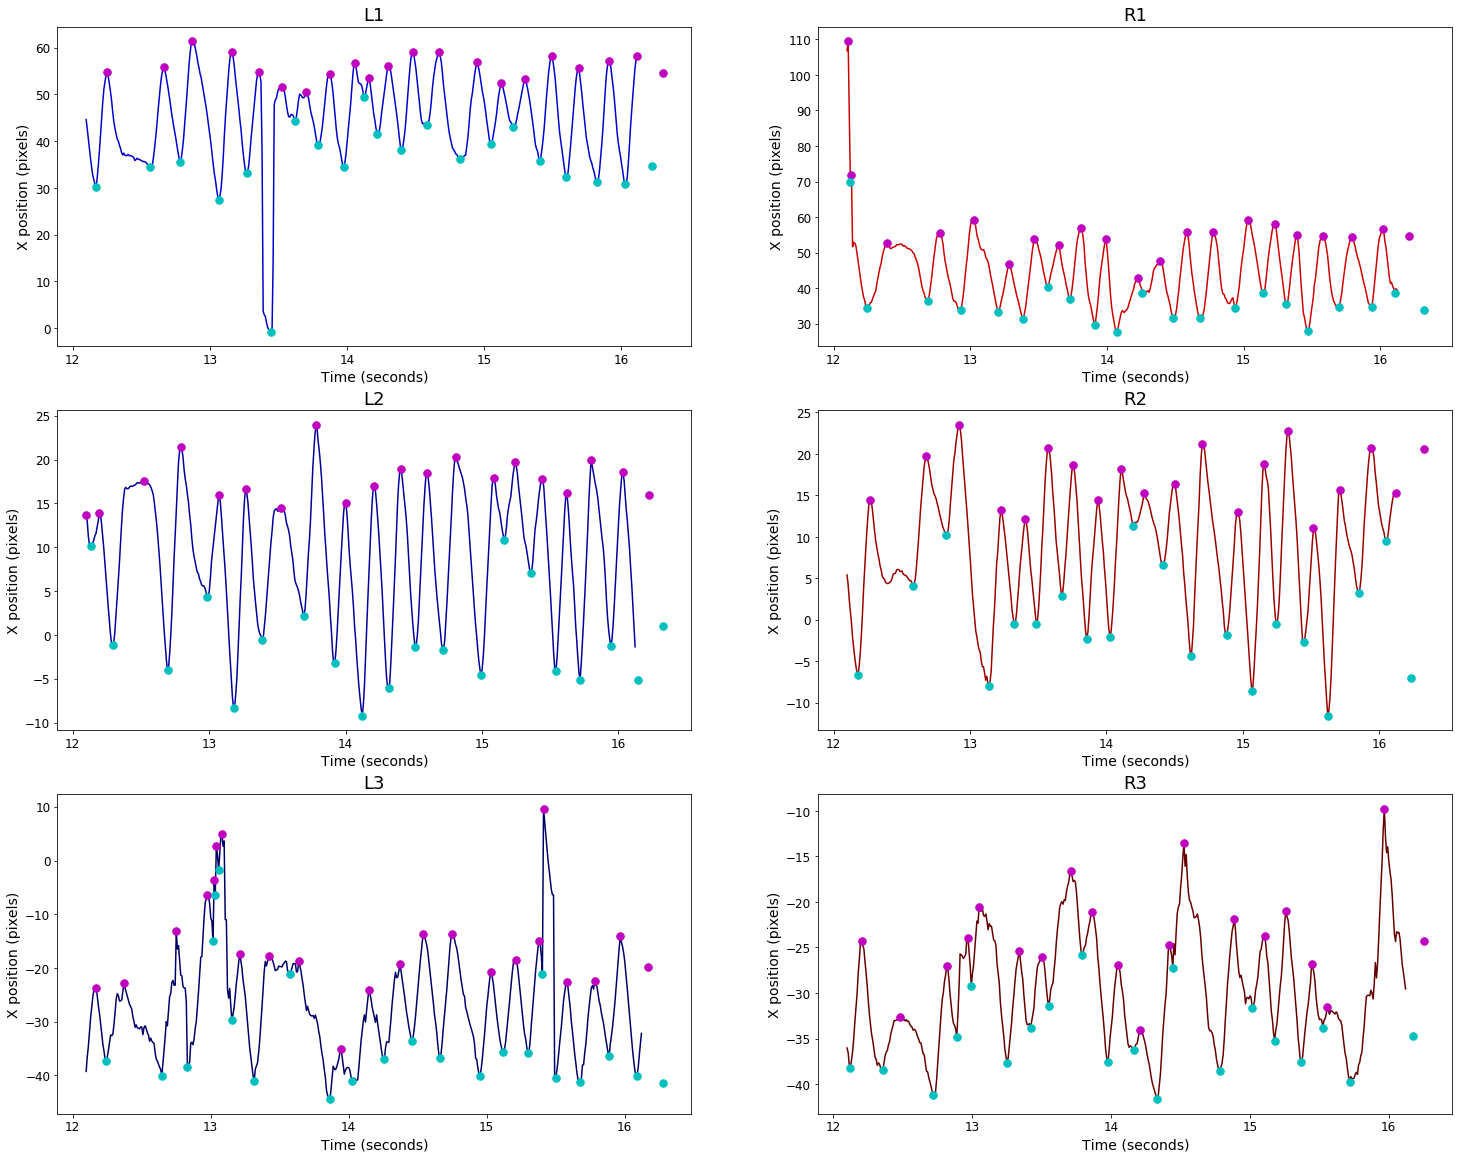

In [15]:
# plot x position of the leg movement of the aligned fly with correct peaks
# filtered
start_frame=1500
end_frame=2025
plt.figure(3, figsize=[25,20])

# left legs
# L1
plt.subplot(3,2,1)
plt.plot(time[frame_start:frame_end], smooth_x_pos[3][frame_start:frame_end], color=[0,0,0.8], linewidth=1.5)
peaks_idxs=l1_max_pks[np.where(np.logical_and(l1_max_pks>=start_frame,l1_max_pks<=end_frame))[0]]
trough_idxs=l1_min_pks[np.where(np.logical_and(l1_min_pks>=start_frame,l1_min_pks<=end_frame))[0]]
plt.plot(time[peaks_idxs], smooth_x_pos[3][peaks_idxs], color='m', marker='.', linestyle='none', markersize=15)
plt.plot(time[trough_idxs], smooth_x_pos[3][trough_idxs], color='c', marker='.', linestyle='none', markersize=15)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('X position (pixels)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('L1', fontsize=18)

# L2
plt.subplot(3,2,3)
plt.plot(time[frame_start:frame_end], smooth_x_pos[4][frame_start:frame_end], color=[0,0,0.6], linewidth=1.5)
peaks_idxs=l2_max_pks[np.where(np.logical_and(l2_max_pks>=start_frame,l2_max_pks<=end_frame))[0]]
trough_idxs=l2_min_pks[np.where(np.logical_and(l2_min_pks>=start_frame,l2_min_pks<=end_frame))[0]]
plt.plot(time[peaks_idxs], smooth_x_pos[4][peaks_idxs], color='m', marker='.', linestyle='none', markersize=15)
plt.plot(time[trough_idxs], smooth_x_pos[4][trough_idxs], color='c', marker='.', linestyle='none', markersize=15)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('X position (pixels)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('L2', fontsize=18)

# L3
plt.subplot(3,2,5)
plt.plot(time[frame_start:frame_end],  smooth_x_pos[5][frame_start:frame_end], color=[0,0,0.4], linewidth=1.5)
peaks_idxs=l3_max_pks[np.where(np.logical_and(l3_max_pks>=start_frame,l3_max_pks<=end_frame))[0]]
trough_idxs=l3_min_pks[np.where(np.logical_and(l3_min_pks>=start_frame,l3_min_pks<=end_frame))[0]]
plt.plot(time[peaks_idxs], smooth_x_pos[5][peaks_idxs], color='m', marker='.', linestyle='none', markersize=15)
plt.plot(time[trough_idxs], smooth_x_pos[5][trough_idxs], color='c', marker='.', linestyle='none', markersize=15)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('X position (pixels)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('L3', fontsize=18)

# right legs
# r1
plt.subplot(3,2,2)
plt.plot(time[frame_start:frame_end], smooth_x_pos[0][frame_start:frame_end], color=[0.8,0,0], linewidth=1.5)
peaks_idxs=r1_max_pks[np.where(np.logical_and(r1_max_pks>=start_frame,r1_max_pks<=end_frame))[0]]
trough_idxs=r1_min_pks[np.where(np.logical_and(r1_min_pks>=start_frame,r1_min_pks<=end_frame))[0]]
plt.plot(time[peaks_idxs], smooth_x_pos[0][peaks_idxs], color='m', marker='.', linestyle='none', markersize=15)
plt.plot(time[trough_idxs], smooth_x_pos[0][trough_idxs], color='c', marker='.', linestyle='none', markersize=15)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('X position (pixels)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('R1', fontsize=18)

# R2
plt.subplot(3,2,4)
plt.plot(time[frame_start:frame_end], smooth_x_pos[1][frame_start:frame_end], color=[0.6,0,0], linewidth=1.5)
peaks_idxs=r2_max_pks[np.where(np.logical_and(r2_max_pks>=start_frame,r2_max_pks<=end_frame))[0]]
trough_idxs=r2_min_pks[np.where(np.logical_and(r2_min_pks>=start_frame,r2_min_pks<=end_frame))[0]]
plt.plot(time[peaks_idxs], smooth_x_pos[1][peaks_idxs], color='m', marker='.', linestyle='none', markersize=15)
plt.plot(time[trough_idxs], smooth_x_pos[1][trough_idxs], color='c', marker='.', linestyle='none', markersize=15)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('X position (pixels)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('R2', fontsize=18)

# R3
plt.subplot(3,2,6)
plt.plot(time[frame_start:frame_end], smooth_x_pos[2][frame_start:frame_end], color=[0.4,0,0], linewidth=1.5)
peaks_idxs=r3_max_pks[np.where(np.logical_and(r3_max_pks>=start_frame,r3_max_pks<=end_frame))[0]]
trough_idxs=r3_min_pks[np.where(np.logical_and(r3_min_pks>=start_frame,r3_min_pks<=end_frame))[0]]
plt.plot(time[peaks_idxs], smooth_x_pos[2][peaks_idxs], color='m', marker='.', linestyle='none', markersize=15)
plt.plot(time[trough_idxs], smooth_x_pos[2][trough_idxs], color='c', marker='.', linestyle='none', markersize=15)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('X position (pixels)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('R3', fontsize=18)


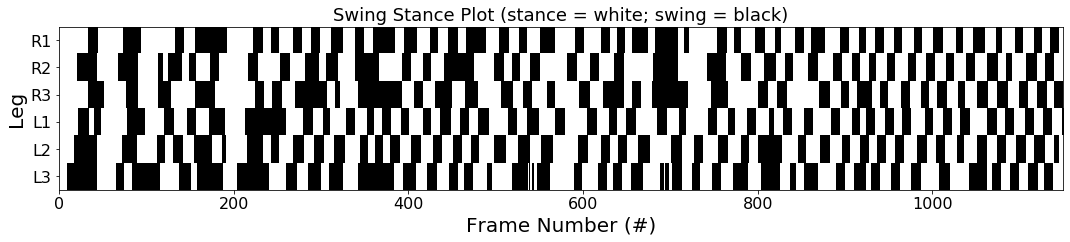

In [58]:
# plot swing stance
start_frame=100
end_frame=1250
plt1=plt.figure(5, figsize=[18,3])
#     plt.rc('xtick', labelsize = 60)
#     plt.rc('ytick', labelsize = 60)
title = 'Swing Stance Plot (stance = white; swing = black)'
plt.title(title, fontsize = 18)
plt.xlabel('Frame Number (#)', fontsize = 20)
plt.ylabel('Leg', fontsize = 20)
labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
axes = plt.gca()
axes.set_yticks(np.arange(0, 6, 1))
axes.set_yticklabels(labels, fontsize=16)
plt.xticks(fontsize=16)
plt.imshow(swing_stance_mat[:,start_frame:end_frame], interpolation = 'none', cmap = 'gray',aspect='auto')
fig_name= 'Clandinin swing stance.png'
plt1.savefig(fig_name, dpi=1000)

### Compute interlimb parameters

1) TCS

2) Number of Legs in Stance

3) Phase

4) Stance start time

5) leg velocity

### Tripod Coordination Strength

### Number of Legs in Stance

Text(0.5, 1.0, 'Number os Legs in Stance')

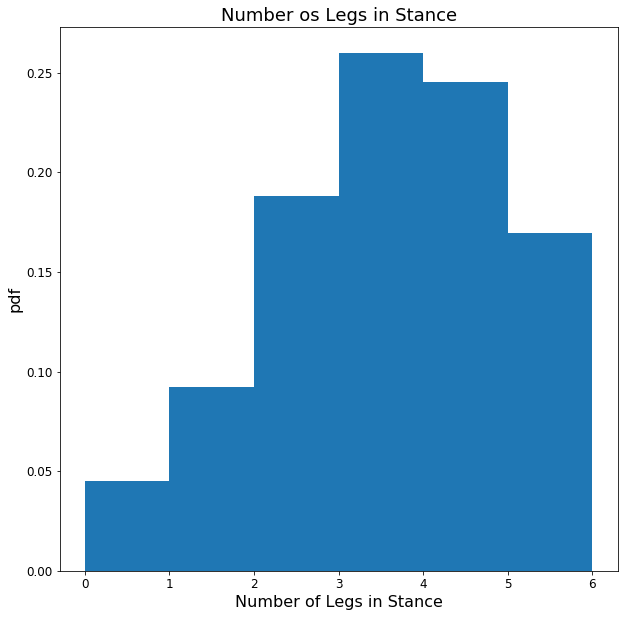

In [25]:
nlegs_stance=np.sum(swing_stance_mat,axis=0)

# plot a histogram
plt.figure(2, figsize=[10,10])
plt.hist(nlegs_stance, bins=6,density=True)
plt.ylabel('pdf', fontsize=16)
plt.xlabel('Number of Legs in Stance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Legs in Stance', fontsize=18)

### Phase

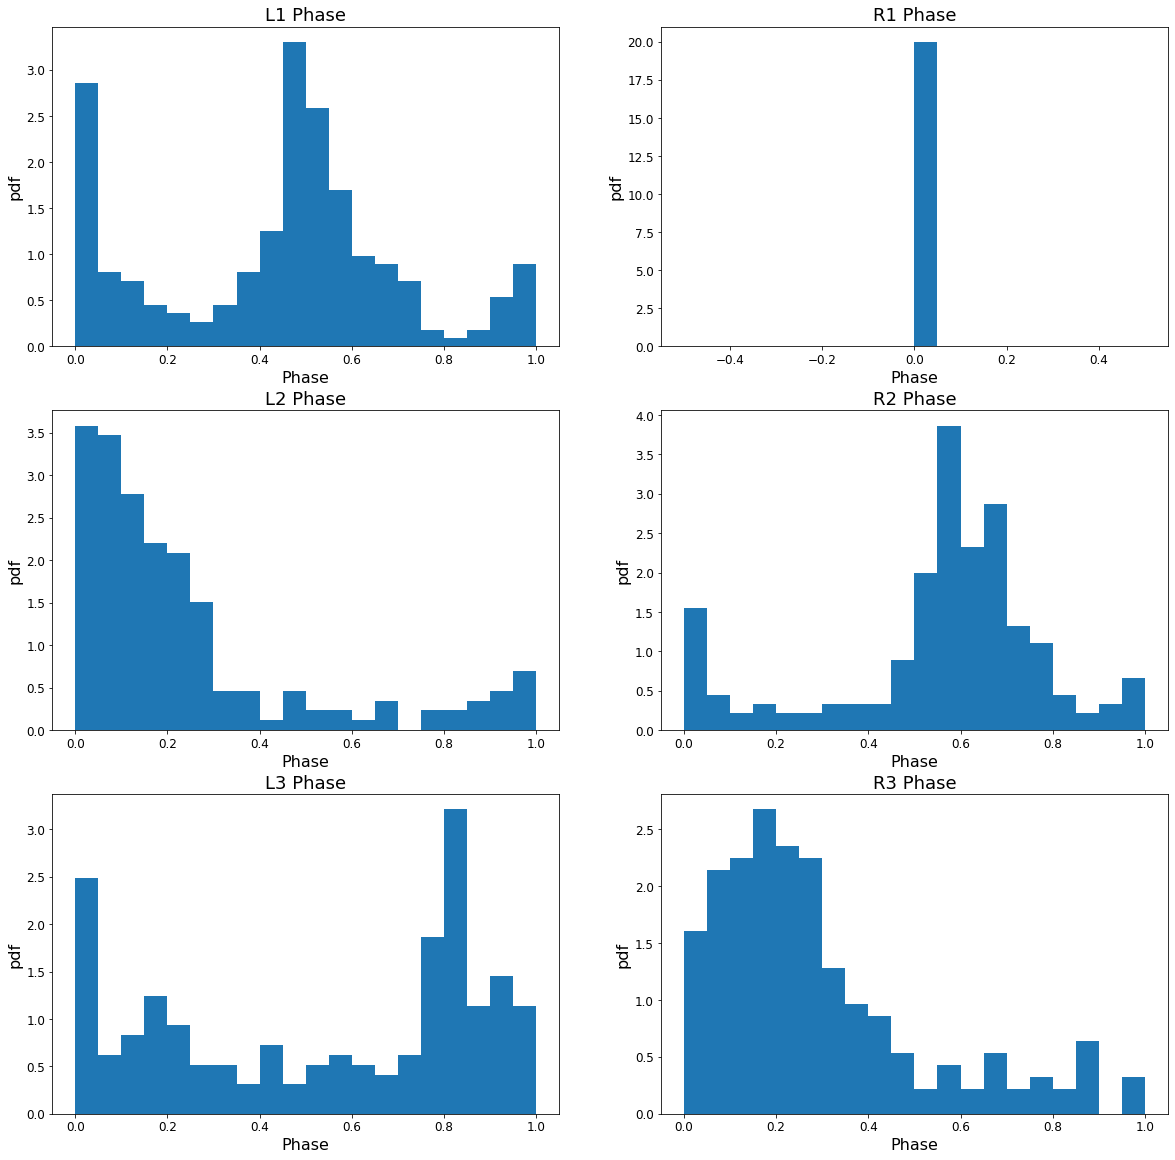

In [33]:
# use r1 as the reference leg
r1_ref=stance_start[0]
phase=[]
leg_name=['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
plot_order=[2,4,6,1,3,5]
ref_step_time=[] # reference step time
plt.figure(3, figsize=[20,20])
for leg in range(nlegs):
    phase_leg= np.zeros(len(r1_ref)-1)

    for j in range(0,len(r1_ref)-1):
        # specify phase range
        step_start=r1_ref[j] # start of a stance
        step_end=r1_ref[j+1] # end of current step and the start of the next step

        # find if the leg in focus has any indices in that region and if so, take the first one (theoretically, there shouldne't be more)
        curr_step=np.where(np.logical_and(stance_start[leg]>=step_start, stance_start[leg] <= step_end))[0]

        # compute phase
        if curr_step.size ==0:
            # if leg is not during the step cycles of the other leg
            phase_leg[j] = np.nan
        else:
            # calculate the phase
            curr_phase=(stance_start[leg][curr_step[0]]-step_start)/(step_end-step_start)
            phase_leg[j] = curr_phase
            
    # plot a histogram
    plt.subplot(3,2,plot_order[leg])
    plt.hist(phase_leg, bins=20,density=True)
    plt.ylabel('pdf', fontsize=16)
    plt.xlabel('Phase', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(leg_name[leg] + ' Phase', fontsize=18)

    phase.append(phase_leg)

### Relative Stance Times

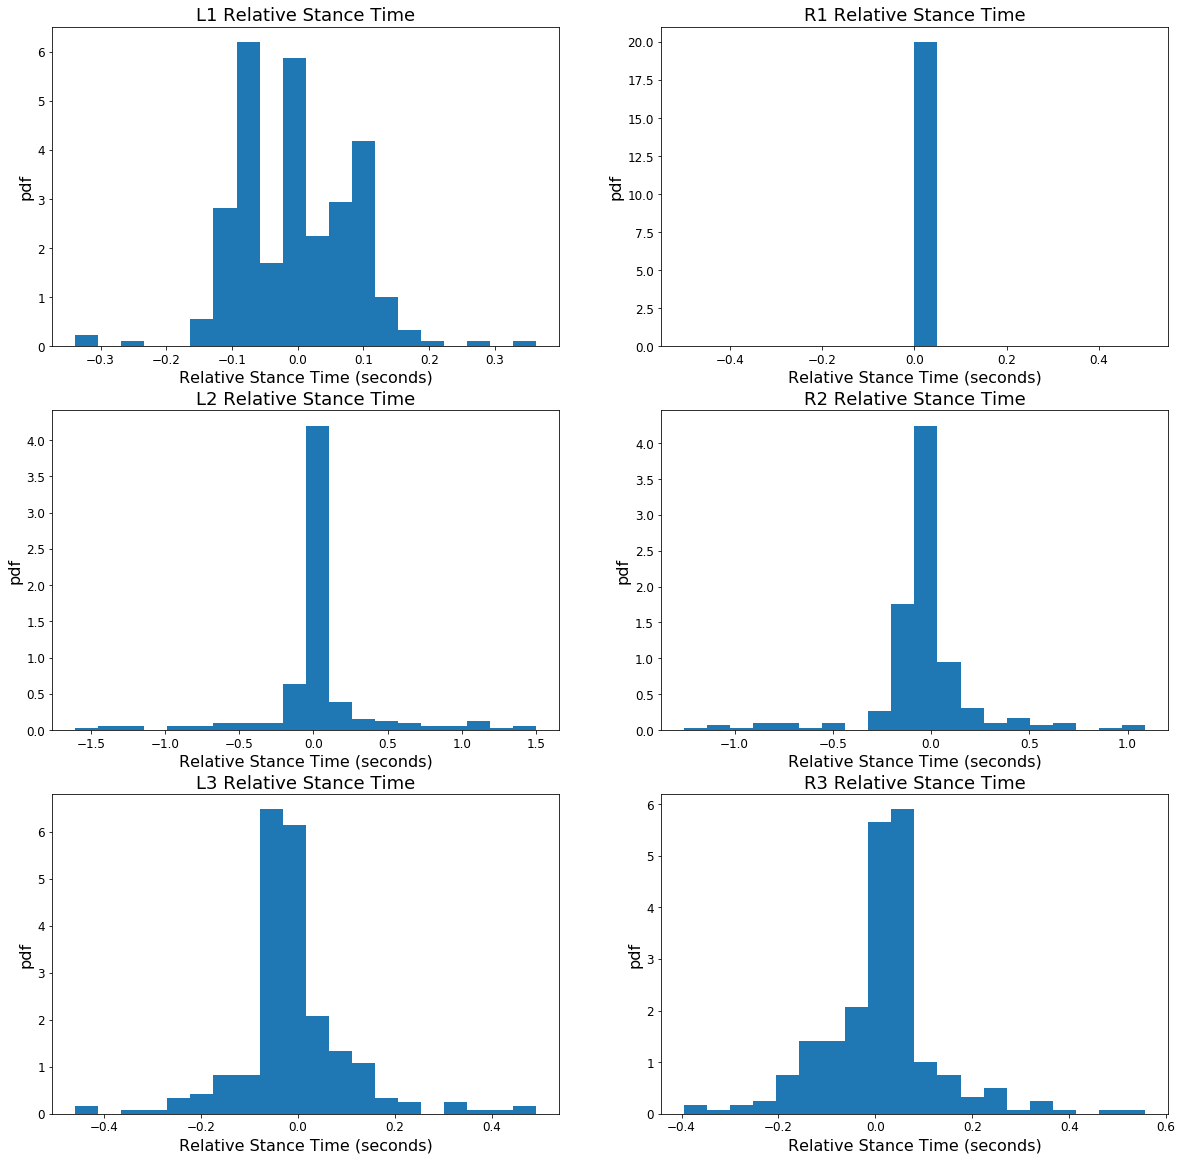

In [36]:
# reference leg (R1)
ref_stance = stance_start[0]/FS
relative_stance=[]
# plt.figure(1,figsize=[25,15])
# image_num=[1, 3, 5, 2, 4, 6]
leg_name=['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
plot_order=[2,4,6,1,3,5]
plt.figure(3, figsize=[20,20])
for leg in range(nlegs):
    relative_stance_leg=np.zeros(len(ref_stance))
    # compare the stance start time to the reference's
    for j in range(len(ref_stance)):

        # current reference stance
        curr_stance=ref_stance[j]

        # stances of comparasion leg
        stances=stance_start[leg]/FS

        # difference between time
        dt= stances - curr_stance

        # find the minmum time differences
        min_idx=np.argmin(abs(dt))

        # relative stance time
        relative_stance_leg[j]= dt[min_idx]
    
    # plot a histogram
    plt.subplot(3,2,plot_order[leg])
    plt.hist(relative_stance_leg, bins=20, density=True)
    plt.ylabel('pdf', fontsize=16)
    plt.xlabel('Relative Stance Time (seconds)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(leg_name[leg] + ' Relative Stance Time', fontsize=18)

    # store relative stances for each leg
    relative_stance.append(relative_stance_leg)

### Leg Velocity

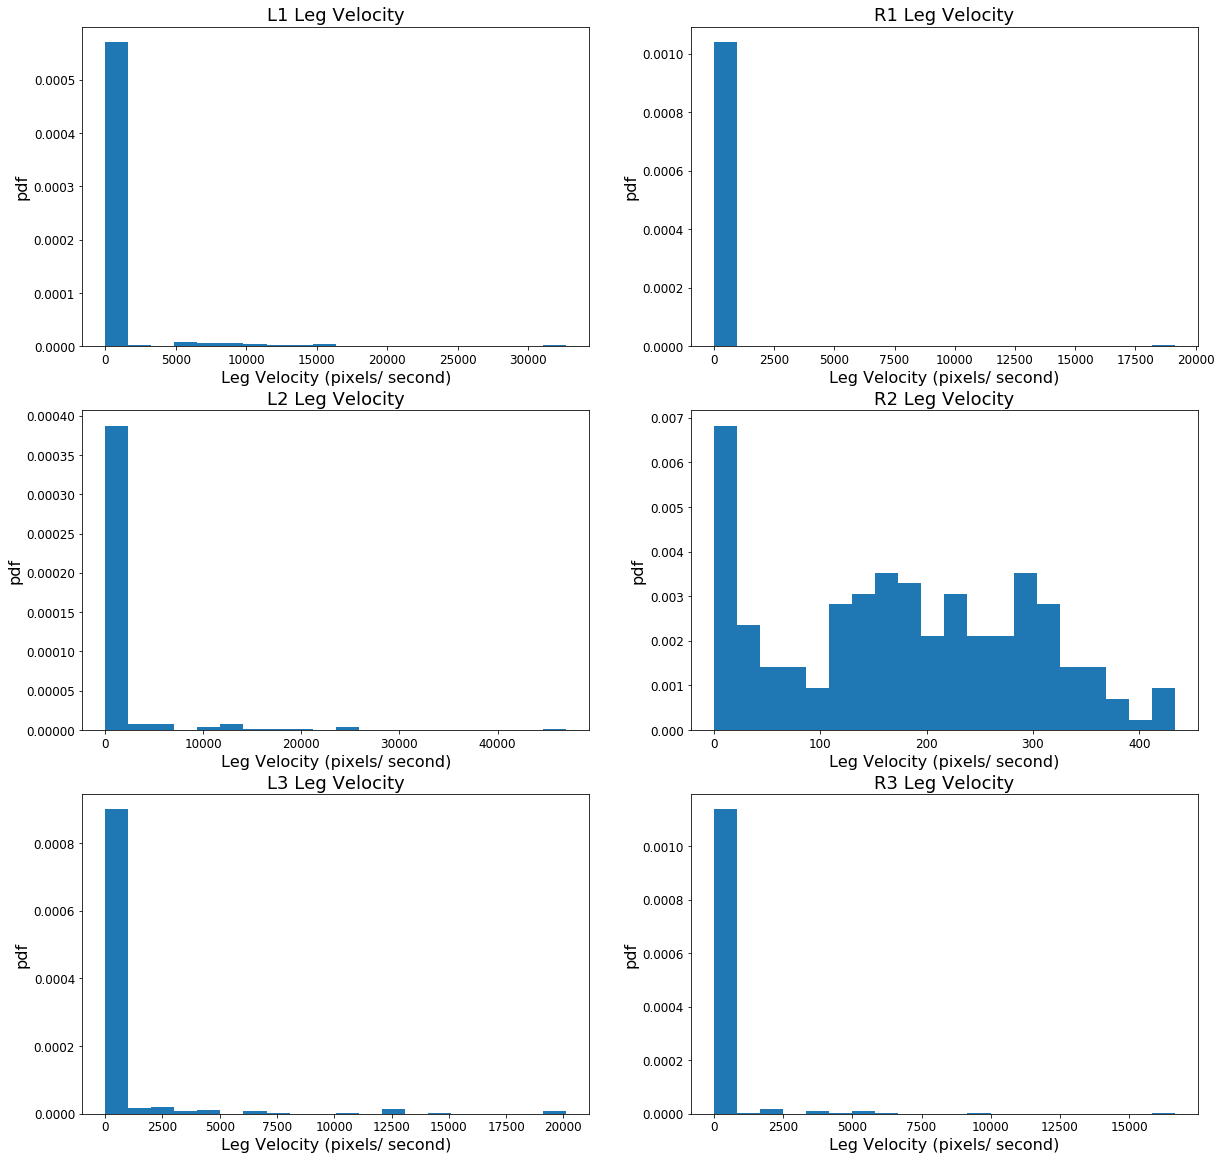

In [40]:
step_velocity=[]
leg_name=['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
plot_order=[2,4,6,1,3,5]
plt.figure(4, figsize=[20,20])
for leg in range(len(stance_start)):
    leg_step_velocity=np.zeros(len(stance_start[leg]))

    # iterate through each step of a leg
    for j in range(len(stance_start[leg])-1):

        # compute 3D stance distance
        dx_stance=x_pos[leg][stance_end[leg][j]]-x_pos[leg][stance_start[leg][j]]
        dy_stance=y_pos[leg][stance_end[leg][j]]-y_pos[leg][stance_start[leg][j]]
        stance_distance=math.sqrt(dx_stance**2 + dy_stance**2)

        # compute 3D swing distance
        dx_swing=x_pos[leg][stance_end[leg][j]]-x_pos[leg][stance_start[leg][j+1]]
        dy_swing=y_pos[leg][stance_end[leg][j]]-y_pos[leg][stance_start[leg][j+1]]
        swing_distance=math.sqrt(dx_swing**2 + dy_swing**2)

        # total distance traveled during step
        total_distance= stance_distance + swing_distance

        # total time of step in seconds
        tot_time = (stance_start[leg][j+1] - stance_start[leg][j])/FS

        # calculate velocity of the step
        vel_step= total_distance / tot_time
        leg_step_velocity[j] = vel_step
    
    # plot a histogram
    plt.subplot(3,2,plot_order[leg])
    plt.hist(leg_step_velocity, bins=20, density=True)
    plt.ylabel('pdf', fontsize=16)
    plt.xlabel('Leg Velocity (pixels/ second)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(leg_name[leg] + ' Leg Velocity', fontsize=18)

    step_velocity.append(leg_step_velocity)

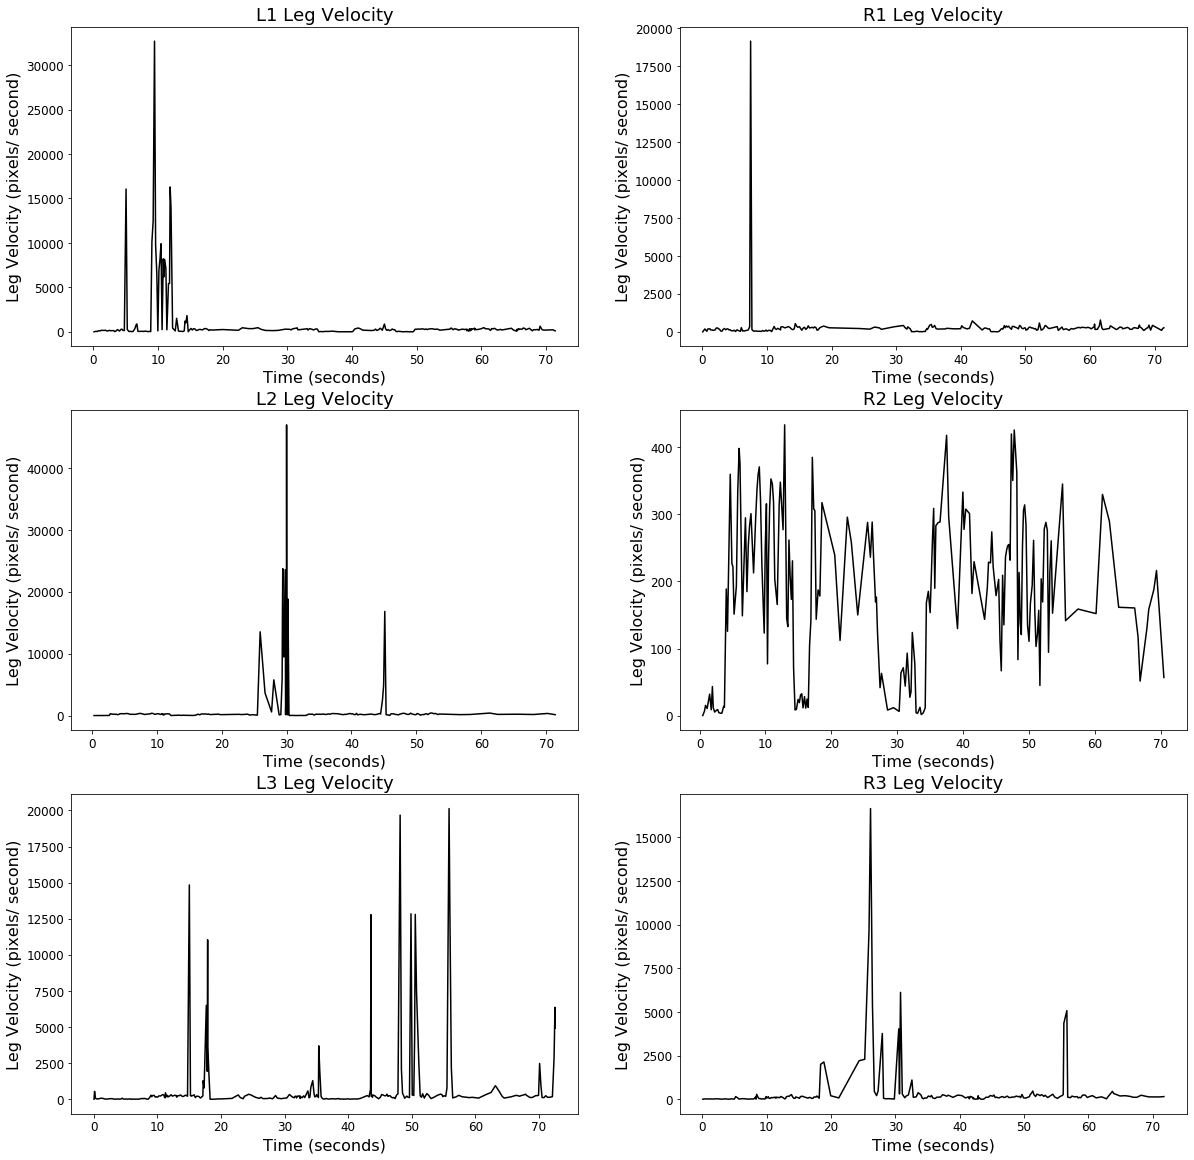

In [41]:
step_velocity=[]
leg_name=['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
plot_order=[2,4,6,1,3,5]
plt.figure(4, figsize=[20,20])
for leg in range(len(stance_start)):
    leg_step_velocity=np.zeros(len(stance_start[leg]))

    # iterate through each step of a leg
    for j in range(len(stance_start[leg])-1):

        # compute 3D stance distance
        dx_stance=x_pos[leg][stance_end[leg][j]]-x_pos[leg][stance_start[leg][j]]
        dy_stance=y_pos[leg][stance_end[leg][j]]-y_pos[leg][stance_start[leg][j]]
        stance_distance=math.sqrt(dx_stance**2 + dy_stance**2)

        # compute 3D swing distance
        dx_swing=x_pos[leg][stance_end[leg][j]]-x_pos[leg][stance_start[leg][j+1]]
        dy_swing=y_pos[leg][stance_end[leg][j]]-y_pos[leg][stance_start[leg][j+1]]
        swing_distance=math.sqrt(dx_swing**2 + dy_swing**2)

        # total distance traveled during step
        total_distance= stance_distance + swing_distance

        # total time of step in seconds
        tot_time = (stance_start[leg][j+1] - stance_start[leg][j])/FS

        # calculate velocity of the step
        vel_step= total_distance / tot_time
        leg_step_velocity[j] = vel_step
    
    # plot a histogram
    plt.subplot(3,2,plot_order[leg])
    plt.plot(stance_start[leg][::-1]/FS, leg_step_velocity,color='black')
    plt.ylabel('Leg Velocity (pixels/ second)', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(leg_name[leg] + ' Leg Velocity', fontsize=18)

    step_velocity.append(leg_step_velocity)

### Interlimb coordination vs. instaneous velocity (scatter plot or 2D histogram)

### Save data as a .csv or .h5 for analysis in R